In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import *
from scipy.linalg import expm
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes
from scipy import stats

In [5]:
# Range of time (unit: year)
t = arange(0, 650, 1)
time = arange(2000, 2000 + len(t))
# Range of age (unit: year)
age = arange(1, 1001)
# Concentration of CO2
X_at = [1715 * exp(0.0305 * ti) / (1715 + exp(0.0305 * ti) - 1) + 284 for ti in t]
# Global annual mean temperature
sigma = 4.5
Ts = [15 + (sigma / log(2)) * log(Xa / 285)
      for Xa in X_at]

############# Input #############
x = 0.65
Gamma_Ts = [42.7 + 1.68 * (T - 25) + 0.012 * (T - 25) ** 2 for T in Ts]
Beta_X_Ts = [(3 * x * Xa * Gamma) / ((x * Xa - Gamma) * (x * Xa + 2 * Gamma)) for Xa, Gamma in zip(X_at, Gamma_Ts)]
s0 = 300 # Input at initial time
# Input
S1 = [s0 * (1 + 2.14 * Beta * log(Xa / 285)) for Beta, Xa in zip(Beta_X_Ts, X_at)]
# Temperature scale
Var = [2 ** (0.1 * new - 1.5) for new in Ts]

"\n                    C_s_MM = K_s / (list_v_s_MM[0] / list_u_b[0] * list_cue[0] / (list_cue[0] + k * (1 - list_cue[0])) - 1)\n                    C_b_MM = S1[0] / (list_u_b[0] * (list_cue[0] ** (-1) - 1))\n                    C_l_MM = K_l / (list_cue[0] * list_V_l_MM[0] / (1 - list_cue[0]) / (1 - k) / list_u_b[0] - 1)\n                    B0_MM = mat([\n                        [-C_b_MM * list_V_l_MM[0] / (C_l_MM + K_l), 0, 0],\n                        [0, -C_b_MM * list_v_s_MM[0] / (C_s_MM + K_s), list_u_b[0]],\n                        [list_cue[0] * C_b_MM * list_V_l_MM[0] / (C_l_MM + K_l),\n                         list_cue[0] * C_b_MM * list_v_s_MM[0] / (C_s_MM + K_s), -list_u_b[0]]])\n                    U_t = mat([\n                        [(1 - k) * S1[0]],\n                        [k * S1[0]],\n                        [0]])\n                    p0_MM = [expm(age1 * B0_MM) * U_t for age1 in age]\n\n                    age_density_l_MM = []\n                    age_density_s_MM 

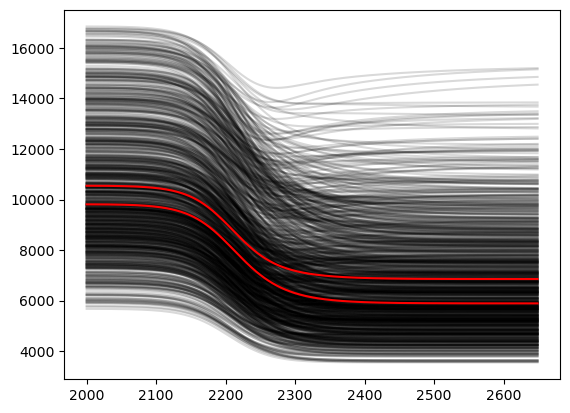

In [10]:
########
# Nonlinear microbial model with regular Michaelis-Menten kinetics
########
list_V_l_MM = [172 * exp(0.063 * (T - 15)) for T in Ts]
v_s_MM = linspace(10, 50, 100) # Maximum uptake rate in MM
cue = linspace(0.2, 0.6, 100)
u_b = linspace(0.1, 0.9, 100)
k = 0.1
K_b = 100
K_l = 67275
K_s = 363871
number = 1000

list_P_a_MM_first = []
list_P_a_MM_last = []
list_P_a_MM_l_first = [] # Mean age at steady state in rMM
list_P_a_MM_l_last = [] # Mean age in the last year in rMM
list_P_a_MM_s_first = [] # Mean age at steady state in rMM
list_P_a_MM_s_last = [] # Mean age in the last year in rMM
list_P_a_MM_b_first = [] # Mean age at steady state in rMM
list_P_a_MM_b_last = [] # Mean age in the last year in rMM

list_EPI_MM = []
list_V_S_MM = []
list_U_B_MM = []
arr_MM = array([[]] * 653)
arr_MM_l = array([[]] * 653)
arr_MM_b = array([[]] * 653)

arr_MM_3d = empty(shape=(1, 650, 1000))
arr_MM_3d_l = empty(shape=(1, 650, 1000))
arr_MM_3d_s = empty(shape=(1, 650, 1000))
arr_MM_3d_b = empty(shape=(1, 650, 1000))

plt.figure()
while number >= 1:
    CUE = random.choice(cue)
    V_S = random.choice(v_s_MM)
    U_B = random.choice(u_b)
    list_cue = [CUE - 0.016 * (T - 15) for T in Ts]
    if min(list_cue) > 0:
        list_v_s_MM = [V_S * exp(0.07 * (T - 15)) for T in Ts]
        list_u_b = [U_B]
        C_l_ini_MM = K_l / (list_cue[0] * list_V_l_MM[0] / ((1 - list_cue[0]) * (1 - k) * list_u_b[0]) - 1)
        C_b_ini_MM = S1[0] / (list_u_b[0] * (list_cue[0] ** (-1) - 1))
        C_s_ini_MM = K_s / (list_v_s_MM[0] / list_u_b[0] * list_cue[0] / (list_cue[0] + 0.1 * (1 - list_cue[0])) - 1)
        list_C_l_MM = []
        list_C_s_MM = []
        list_C_b_MM = []
        if C_s_ini_MM < 16000:
            for e, Vs, Vl, S11 in zip(list_cue, list_v_s_MM, list_V_l_MM, S1):
                uptake_L = C_b_ini_MM * Vl / (C_l_ini_MM + K_l)
                uptake_S = C_b_ini_MM * Vs / (C_l_ini_MM + K_l)
                if uptake_L < 1 and uptake_S < 1:
                    del_C_l_B = (1 - k) * S11 - C_b_ini_MM * Vl * C_l_ini_MM / (C_l_ini_MM + K_l)
                    del_C_s_B = k * S11 + U_B * C_b_ini_MM - C_b_ini_MM * Vs * C_s_ini_MM / (C_s_ini_MM + K_s)
                    del_C_b_B = e * C_b_ini_MM * (
                            Vl * C_l_ini_MM / (C_l_ini_MM + K_l) + Vs * C_s_ini_MM / (C_s_ini_MM + K_s)) - U_B * C_b_ini_MM
                    C_l_ini_MM = C_l_ini_MM + del_C_l_B
                    C_s_ini_MM = C_s_ini_MM + del_C_s_B
                    C_b_ini_MM = C_b_ini_MM + del_C_b_B
                    list_C_l_MM.append(C_l_ini_MM)
                    list_C_s_MM.append(C_s_ini_MM)
                    list_C_b_MM.append(C_b_ini_MM)

            if len(list_C_s_MM) == 650:
                if list_C_s_MM[649] - list_C_s_MM[0] < -2000:
                    list_EPI_MM.append(CUE)
                    list_V_S_MM.append(V_S)
                    list_U_B_MM.append(U_B)

                    plt.plot(arange(2000, 2650), [x + y + z for x, y, z in zip(list_C_l_MM, list_C_s_MM, list_C_b_MM)], color='black', alpha=0.15)
                    arr_tem = array(list_C_s_MM)
                    arr_tem2 = insert(arr_tem, 0, [CUE, V_S, U_B])
                    arr_MM = column_stack((arr_MM, arr_tem2))
                    
                    arr_tem_l = array(list_C_l_MM)
                    arr_tem2_l = insert(arr_tem_l, 0, [CUE, V_S, U_B])
                    arr_MM_l = column_stack((arr_MM_l, arr_tem2_l))
                    
                    arr_tem_b = array(list_C_b_MM)
                    arr_tem2_b = insert(arr_tem_b, 0, [CUE, V_S, U_B])
                    arr_MM_b = column_stack((arr_MM_b, arr_tem2_b))
                    
#                     number = number - 1
#     continue
# arr_MM_mean_Cs = average(arr_MM.T, axis=0)
# arr_MM_mean_Cl = average(arr_MM_l.T, axis=0)
# arr_MM_mean_Cb = average(arr_MM_b.T, axis=0)
# all_pool_carbon = arr_MM_mean_Cs + arr_MM_mean_Cl + arr_MM_mean_Cb
# plt.plot(arange(2000, 2650), all_pool_carbon[3:], c='r')
# plt.plot(arange(2000, 2650), arr_MM_mean_Cs[3:], c='r')

# arr_MM = arr_MM.T
# # arr_MM_3d = delete(arr_MM_3d, 0, axis=0)
# save('E://论文//模型//Wang//np_file//20220515//arr_MM_Cs_all', arr_MM)



                    C_s_MM = K_s / (list_v_s_MM[0] / list_u_b[0] * list_cue[0] / (list_cue[0] + k * (1 - list_cue[0])) - 1)
                    C_b_MM = S1[0] / (list_u_b[0] * (list_cue[0] ** (-1) - 1))
                    C_l_MM = K_l / (list_cue[0] * list_V_l_MM[0] / (1 - list_cue[0]) / (1 - k) / list_u_b[0] - 1)
                    B0_MM = mat([
                        [-C_b_MM * list_V_l_MM[0] / (C_l_MM + K_l), 0, 0],
                        [0, -C_b_MM * list_v_s_MM[0] / (C_s_MM + K_s), list_u_b[0]],
                        [list_cue[0] * C_b_MM * list_V_l_MM[0] / (C_l_MM + K_l),
                         list_cue[0] * C_b_MM * list_v_s_MM[0] / (C_s_MM + K_s), -list_u_b[0]]])
                    U_t = mat([
                        [(1 - k) * S1[0]],
                        [k * S1[0]],
                        [0]])
                    p0_MM = [expm(age1 * B0_MM) * U_t for age1 in age]

                    age_density_l_MM = []
                    age_density_s_MM = []
                    age_density_b_MM = []

                    # soc_l_MM_dataframe = pd.DataFrame(columns=['year', 'soc_l_B'])
                    Input_l_MM = [(1 - k) * S1[yr - 2000] for yr in time]
                    pa_pre_MM = p0_MM.copy()
                    pa_pre_MM = hstack(pa_pre_MM)
                    pa_pre1000_l_MM = list(array(pa_pre_MM[0, :len(age)]).reshape(len(age), ))
                    ##########################################################################
                    # soc_s_MM_dataframe = pd.DataFrame(columns=['year', 'soc_s_B'])
                    Input_s_MM = [(k) * S1[yr - 2000] for yr in time]
                    pa_pre1000_s_MM = list(array(pa_pre_MM[1, :len(age)]).reshape(len(age), ))
                    ##########################################################################
                    # soc_b_MM_dataframe = pd.DataFrame(columns=['year', 'soc_b_B'])
                    Input_b_MM = [0]
                    pa_pre1000_b_MM = list(array(pa_pre_MM[2, :len(age)]).reshape(len(age), ))
                    #######################################################################
                    for yr in arange(len(t)):
                        # input
                        pa_pre1000_l_MM = [Input_l_MM[yr]] + list(
                            array(pa_pre1000_l_MM[:len(age)]).reshape(len(age), ))  # 1001
                        pa_pre1000_s_MM = [Input_s_MM[yr]] + list(
                            array(pa_pre1000_s_MM[:len(age)]).reshape(len(age), ))  # 1001
                        # soc_l_MM_dataframe.loc[len(soc_l_MM_dataframe)] = [yr + 2000, sum(pa_pre1000_l_MM[:len(age)])]
                        # soc_s_MM_dataframe.loc[len(soc_s_MM_dataframe)] = [yr + 2000, sum(pa_pre1000_s_MM[:len(age)])]
                        # soc_b_MM_dataframe.loc[len(soc_b_MM_dataframe)] = [yr + 2000, sum(pa_pre1000_b_MM[:len(age)])]
                        # microbial uptake of litter, soil
                        Uptake_l_MM = [list_V_l_MM[yr] * pa_pre1000_l_MM[i] * sum(pa_pre1000_b_MM) / (pa_pre1000_l_MM[i] + K_l)
                                       for i in
                                       arange(len(age) + 1)]
                        Uptake_s_MM = [list_v_s_MM[yr] * pa_pre1000_s_MM[i] * sum(pa_pre1000_b_MM) / (pa_pre1000_s_MM[i] + K_s)
                                       for i in
                                       arange(len(age) + 1)]
                        # microbial decay
                        decay_mic_MM = list_u_b[0] * array(pa_pre1000_b_MM)  # age:2-1001

                        pa_present_l_MM = array(pa_pre1000_l_MM) - array(Uptake_l_MM)  # age: 1-1001
                        pa_pre1000_l_MM = pa_present_l_MM[:len(age)].copy().tolist()
                        age_density_l_MM = age_density_l_MM + pa_pre1000_l_MM

                        pa_present_s_MM = array(pa_pre1000_s_MM) - array(Uptake_s_MM) + insert(decay_mic_MM, 0,
                                                                                               0)  # age: 1-1001
                        pa_pre1000_s_MM = pa_present_s_MM[:len(age)].copy().tolist()
                        age_density_s_MM = age_density_s_MM + pa_pre1000_s_MM

                        pa_present_b_MM = insert((pa_pre1000_b_MM - decay_mic_MM), 0, 0) + list_cue[yr] * array(
                            Uptake_l_MM) + list_cue[yr] * array(
                            Uptake_s_MM)
                        pa_pre1000_b_MM = pa_present_b_MM[:len(age)].copy().tolist()
                        age_density_b_MM = age_density_b_MM + pa_pre1000_b_MM

                    age_density_l_MM = array(age_density_l_MM).reshape(len(time), len(age))
                    age_density_s_MM = array(age_density_s_MM).reshape(len(time), len(age))
                    age_density_b_MM = array(age_density_b_MM).reshape(len(time), len(age))
                    
                    age_density_carbon_MM = age_density_l_MM + age_density_b_MM + age_density_s_MM
                    age_density_carbon_MM = age_density_carbon_MM / age_density_carbon_MM.sum(axis=1)[:, None]

                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_carbon_MM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_carbon_MM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)

                    list_P_a_MM_first.append(mean_tem)
                    list_P_a_MM_last.append(mean_tem2)

                    ###### litter
                    age_density_l_carbon_MM = age_density_l_MM / age_density_l_MM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_l_carbon_MM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_l_carbon_MM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_MM_l_first.append(mean_tem)
                    list_P_a_MM_l_last.append(mean_tem2)

                    ###### soil
                    age_density_s_carbon_MM = age_density_s_MM / age_density_s_MM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_s_carbon_MM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_s_carbon_MM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_MM_s_first.append(mean_tem)
                    list_P_a_MM_s_last.append(mean_tem2)

                    ###### microbe
                    age_density_b_carbon_MM = age_density_b_MM / age_density_b_MM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_b_carbon_MM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_b_carbon_MM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_MM_b_first.append(mean_tem)
                    list_P_a_MM_b_last.append(mean_tem2)

                    age_density_carbon_MM_tem = age_density_carbon_MM[newaxis, :]
                    arr_MM_3d = vstack((arr_MM_3d, age_density_carbon_MM_tem))

                    age_density_carbon_MM_tem_l = age_density_l_carbon_MM[newaxis, :]
                    arr_MM_3d_l = vstack((arr_MM_3d_l, age_density_carbon_MM_tem_l))
                    
                    age_density_carbon_MM_tem_s = age_density_s_carbon_MM[newaxis, :]
                    arr_MM_3d_s = vstack((arr_MM_3d_s, age_density_carbon_MM_tem_s))
                    
                    age_density_carbon_MM_tem_b = age_density_b_carbon_MM[newaxis, :]
                    arr_MM_3d_b = vstack((arr_MM_3d_b, age_density_carbon_MM_tem_b))
                    
                    number = number - 1
    continue

arr_MM = arr_MM.T
arr_MM_l = arr_MM_l.T
arr_MM_b = arr_MM_b.T
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_Cs_1000', arr_MM)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_Cl_1000', arr_MM_l)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_Cb_1000', arr_MM_b)

# arr_MM_3d = delete(arr_MM_3d, 0, axis=0)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_3d_1000', arr_MM_3d)
arr_MM_3d_l = delete(arr_MM_3d_l, 0, axis=0)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_3d_1000', arr_MM_3d_l)
arr_MM_3d_s = delete(arr_MM_3d_s, 0, axis=0)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_3d_1000', arr_MM_3d_s)
arr_MM_3d_b = delete(arr_MM_3d_b, 0, axis=0)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_3d_1000', arr_MM_3d_b)

list_P_a_MM_first = array(list_P_a_MM_first)
list_P_a_MM_last = array(list_P_a_MM_last)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_ma_f_1000', list_P_a_MM_first)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_ma_l_1000', list_P_a_MM_last)

list_P_a_MM_l_first = array(list_P_a_MM_l_first)
list_P_a_MM_l_last = array(list_P_a_MM_l_last)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_l_ma_f_1000', list_P_a_MM_l_first)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_l_ma_l_1000', list_P_a_MM_l_last)

list_P_a_MM_s_first = array(list_P_a_MM_s_first)
list_P_a_MM_s_last = array(list_P_a_MM_s_last)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_s_ma_f_1000', list_P_a_MM_s_first)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_s_ma_l_1000', list_P_a_MM_s_last)

list_P_a_MM_b_first = array(list_P_a_MM_b_first)
list_P_a_MM_b_last = array(list_P_a_MM_b_last)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_b_ma_f_1000', list_P_a_MM_b_first)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/arr_MM_b_ma_l_1000', list_P_a_MM_b_last)

save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/list_EPI_MM', list_EPI_MM)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/list_V_S_MM', list_V_S_MM)
save('/Users/lianleifu/Downloads/Papers/Wang/np_file/20231229/list_U_B_MM', list_U_B_MM)
